In [1]:
from dem_stitcher.datasets import get_dem_tile_extents
import matplotlib.pyplot as plt

In [2]:
df_tiles = get_dem_tile_extents('glo_30')
df_tiles.head()

,geometry,tile_id,url,dem_name
0,"POLYGON ((7.00000 0.00000, 7.00000 1.00000, 6....",Copernicus_DSM_COG_10_N00_00_E006_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/20...,glo_30
1,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ...",Copernicus_DSM_COG_10_N00_00_E009_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/20...,glo_30
2,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ...",Copernicus_DSM_COG_10_N00_00_E010_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/20...,glo_30
3,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ...",Copernicus_DSM_COG_10_N00_00_E011_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/20...,glo_30
4,"POLYGON ((13.00000 0.00000, 13.00000 1.00000, ...",Copernicus_DSM_COG_10_N00_00_E012_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/20...,glo_30


<AxesSubplot:>

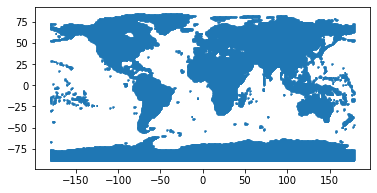

In [3]:
df_tiles.exterior.plot()

In [4]:
df_tiles_missing = get_dem_tile_extents('glo_90_missing')
df_tiles_missing.head()

,geometry,tile_id,url,dem_name
0,"POLYGON ((46.00000 38.00000, 46.00000 39.00000...",Copernicus_DSM_COG_30_N38_00_E045_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/20...,glo_90_missing
1,"POLYGON ((47.00000 38.00000, 47.00000 39.00000...",Copernicus_DSM_COG_30_N38_00_E046_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/20...,glo_90_missing
2,"POLYGON ((49.00000 38.00000, 49.00000 39.00000...",Copernicus_DSM_COG_30_N38_00_E048_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/20...,glo_90_missing
3,"POLYGON ((50.00000 38.00000, 50.00000 39.00000...",Copernicus_DSM_COG_30_N38_00_E049_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/20...,glo_90_missing
4,"POLYGON ((45.00000 39.00000, 45.00000 40.00000...",Copernicus_DSM_COG_30_N39_00_E044_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/20...,glo_90_missing


(38.0, 56.0)

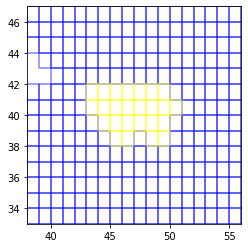

In [8]:
fig, ax = plt.subplots()
xmin, ymin, xmax, ymax = df_tiles_missing.total_bounds

df_tiles.boundary.plot(ax= ax, color='blue', alpha=.5)
df_tiles_missing.boundary.plot(ax=ax, color='yellow', alpha=.5)
ax.set_ylim(ymin-5, ymax+5)
ax.set_xlim(xmin-5, xmax+5)